# Advanced Classification - Neural Networks
- Solve the classification task defined in Module 1 (or define new ones) with the
other classification methods analyzed during the course: Logistic Regression,
Support Vector Machines, Neural Networks, Ensemble Methods, Gradient Boosting
Machines.
- Always perform hyper-parameter tuning phases and justify your choices (which
are the best parameters? which parameters did you test and why?).
- Evaluate each classifier with the techniques presented in DM1: accuracy (or
precision, recall, F1-score etc), ROC curve (or lift, precision-recall etc).
- Besides the numerical evaluation draw your conclusions about the various
classifiers (e.g. for Neural Networks: what are the parameter sets or the
convergence criteria which avoid overfitting? For Ensemble classifiers how the
number of base models impact the classification performance? What is revealing
the feature importance of Random Forests?)

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

from collections import Counter
from collections import defaultdict

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import ADASYN

from sklearn.utils import shuffle

# Data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use("ggplot")
rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)

## Data Preprocessing

In [2]:
# reading the clean dataset with only features selected with filter approaches
# the data is also already normalized (min-max) and cubic-transformed
df_all = pd.read_csv('data/data_full_upto_varThr.csv')

In [3]:
# TRAIN and TEST datasets split (and labels)
targ = 'emotion'
labels = df_all.pop(targ)
df_train, df_test = df_all.loc[:1827,:], df_all.loc[1828:,:]

# vars to encode
cat_vars = list(df_all.loc[:,'vocal_channel':'sex'].columns)

# one hot encoding of train df_train and df_test
df_train = pd.get_dummies(df_train, columns = cat_vars)
df_test = pd.get_dummies(df_test, columns = cat_vars)

# Label Encoder
le = LabelEncoder()
labels = le.fit_transform(labels)
label_encoder_name_mapping = dict(zip(le.classes_,
                                         le.transform(le.classes_)))
print("Mapping of Label Encoded Classes: ", label_encoder_name_mapping, sep="\n")

# splitting the labels in train and test
labels_train, labels_test = labels[:1828], labels[1828:]
df_train.insert(0,str(targ),labels_train)
df_test.insert(0,str(targ),labels_test)

Mapping of Label Encoded Classes: 
{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [4]:
# checking the shapes
print('train and test dfs shape: ', df_train.shape, df_test.shape)
print('train and test labels shape: ', labels_train.shape, labels_test.shape)
df_train.head()

train and test dfs shape:  (1828, 128) (624, 128)
train and test labels shape:  (1828,) (624,)


,emotion,frame_count,sum,skew,lag1_kur,zc_sum,mfcc_sum,mfcc_mean,mfcc_max,mfcc_q05,mfcc_q25,mfcc_q50,mfcc_q75,mfcc_q95,mfcc_q99,sc_sum,sc_mean,sc_std,sc_min,sc_max,sc_q01,sc_q05,sc_q25,sc_q50,sc_q75,sc_q95,sc_q99,sc_kur,stft_sum,sum_w1,kur_w1,skew_w1,lag1_kur_w1,lag1_skew_w1,zc_sum_w1,zc_q95_w1,mfcc_sum_w1,mfcc_mean_w1,mfcc_std_w1,mfcc_max_w1,mfcc_q05_w1,mfcc_q25_w1,mfcc_q50_w1,mfcc_q75_w1,mfcc_q95_w1,mfcc_q99_w1,sc_sum_w1,sc_std_w1,sc_min_w1,sc_q25_w1,sc_q75_w1,sc_q95_w1,sc_kur_w1,sc_skew_w1,stft_sum_w1,stft_kur_w1,sum_w2,kur_w2,zc_sum_w2,mfcc_min_w2,mfcc_max_w2,mfcc_q75_w2,mfcc_q95_w2,mfcc_kur_w2,sc_sum_w2,sc_mean_w2,sc_std_w2,sc_min_w2,sc_max_w2,sc_q05_w2,sc_q25_w2,sc_q50_w2,sc_kur_w2,stft_sum_w2,sum_w3,kur_w3,lag1_kur_w3,zc_sum_w3,mfcc_mean_w3,mfcc_q05_w3,mfcc_q95_w3,mfcc_q99_w3,mfcc_kur_w3,sc_sum_w3,sc_mean_w3,sc_std_w3,sc_min_w3,sc_max_w3,sc_q25_w3,sc_kur_w3,stft_sum_w3,sum_w4,kur_w4,skew_w4,lag1_kur_w4,lag1_skew_w4,zc_sum_w4,zc_q95_w4,mfcc_sum_w4,mfcc_mean_w4,mfcc_std_w4,mfcc_max_w4,mfcc_q25_w4,mfcc_q50_w4,mfcc_q95_w4,mfcc_q99_w4,sc_sum_w4,sc_mean_w4,sc_std_w4,sc_min_w4,sc_max_w4,sc_q25_w4,sc_q75_w4,sc_kur_w4,sc_skew_w4,stft_sum_w4,stft_kur_w4,stft_skew_w4,vocal_channel_song,vocal_channel_speech,emotional_intensity_normal,emotional_intensity_strong,statement_Dogs are sitting by the door,statement_Kids are talking by the door,repetition_1st,repetition_2nd,sex_F,sex_M
0,5,0.106792,0.506722,0.784505,0.260775,0.129522,0.591481,0.423199,0.717587,0.635723,0.896695,0.479183,0.261387,0.447466,0.752627,0.655516,0.954851,0.882301,0.000000,0.705391,0.385894,0.451166,0.560393,0.927656,0.951307,0.950086,0.655447,0.014217,0.528794,0.552984,0.572236,0.618010,0.699286,1.000000,0.062556,0.0,0.445355,0.133570,0.933467,0.265192,0.374045,0.679413,0.329009,0.167593,0.191928,0.483503,0.807990,0.092930,0.975799,0.965340,0.999875,0.935376,0.692039,0.780737,0.853646,0.503824,0.553195,0.691411,0.224991,0.299631,0.628919,0.652833,0.509086,0.438077,0.210342,0.405315,0.593581,0.393472,0.528451,0.404438,0.385595,0.378612,0.087534,0.466630,0.564012,0.590970,0.486622,0.224149,0.591696,0.801812,0.374269,0.833184,0.481993,0.307510,0.365604,0.769611,0.318640,0.578369,0.291006,0.533887,0.553313,0.482849,0.290004,0.738540,0.108887,0.593791,0.448805,1.0,0.597521,0.216581,0.866067,0.159312,0.653604,0.488662,0.281894,0.187912,0.738302,0.964313,0.268862,0.000000,0.901624,0.936516,0.976689,0.958815,0.102331,0.514047,0.988635,0.048224,0,1,1,0,0,1,1,0,0,1
1,5,0.116504,0.503248,0.807974,0.225783,0.148238,0.592678,0.436033,0.598435,0.506675,0.862466,0.479183,0.278588,0.470939,0.729264,0.624961,0.901829,0.812829,0.401039,0.450510,0.467991,0.450760,0.561798,0.799551,0.926962,0.943297,0.633036,0.013852,0.533221,0.600963,0.435323,0.230835,0.467376,0.617102,0.149082,1.0,0.573211,0.331577,0.819130,0.135787,0.516668,0.679413,0.522225,0.469625,0.271325,0.489737,0.764826,0.161923,0.628552,0.909069,0.989784,0.930195,0.638155,0.389996,0.867947,0.192102,0.451680,0.699709,0.198031,0.290148,0.550263,0.603532,0.441019,0.457699,0.226723,0.420190,0.495440,0.525674,0.367284,0.493723,0.394864,0.414946,0.051492,0.519341,0.611536,0.543484,0.539834,0.235869,0.614794,0.852725,0.521718,0.839149,0.449225,0.255697,0.303490,0.658337,0.305612,0.450865,0.293301,0.552003,0.507090,0.510608,0.339563,0.407132,0.128112,0.592731,0.396224,0.0,0.555675,0.159624,0.898993,0.209908,0.632088,0.413982,0.253659,0.267796,0.742450,0.956018,0.268475,0.869244,0.900040,0.872086,0.990271,0.177813,0.526318,0.483277,0.095336,0.360443,0,1,1,0,0,1,0,1,0,1
2,5,0.097081,0.507227,0.872440,0.269902,0.104711,0.602877,0.432130,0.667726,0.887036,0.896088,0.479183,0.235460,0.380469,0.801084,0.619848,0.921414,0.853955,0.000000,0.459613,0.393383,0.431250,0.472504,0.911578,0.930051,0.947636,0.642306,0.013639,0.495870,0.599825,0.100512,0.413890,0.112541,0.527296,0.149221,1.0,0.602522,0.342404,0.821121,0.156563,0.832058,0.701664,0.558589,0.466631,0.278917,0.491881,0.754973,0.123756,0.799765,0.905290,0.993358,0.930973,0.494276,0.4

In [5]:
# if we want to oversample the data
def apply_ADASYN(X, y):
    # oversampling the minority class for balanced learning
    from imblearn.over_sampling import ADASYN
    ada = ADASYN(random_state = 42)
    X, y = ada.fit_resample(X, y)
    print('resampled training set: ', X.shape, y.shape)
    print('target var. class frequencies:')
    print(Counter(y))
    return X, y

In [6]:
# converting df_train and df_test into np matrices and arrays
X, X_test = df_train.iloc[:,1:].values, df_test.iloc[:,1:].values
y, y_test = df_train.loc[:,targ].values, df_test.loc[:,targ].values

# shuffling train and val concatenation to remove potential pattern bias
X, y  = shuffle(X, y, random_state=42)

RUN THE CODE BLOCK BELOW FOR OVERSAMPLED VERSION (Only Classification)

In [7]:
# adasyn oversampling
#X, y = apply_ADASYN(X,y)

In [8]:
# split train/val = 80/20
split_idx = df_train.shape[0]-int(df_train.shape[0]*0.2)
X_train, X_val = X[:split_idx,:], X[split_idx:,:]
y_train, y_val = y[:split_idx], y[split_idx:]

print('X_train: ', X_train.shape, 'y_train: ', y_train.shape)
print('X_val: ', X_val.shape, 'y_val: ', y_val.shape)
print()

print('target variable classes frequencies:')
print()
print('training set: ',Counter(y_train))
print('validation set: ',Counter(y_val))
print('test set: ',Counter(labels_test))

X_train:  (1463, 127) y_train:  (1463,)
X_val:  (365, 127) y_val:  (365,)

target variable classes frequencies:

training set:  Counter({0: 233, 1: 230, 3: 220, 4: 220, 6: 213, 2: 116, 5: 116, 7: 115})
validation set:  Counter({6: 67, 4: 60, 3: 60, 1: 50, 0: 47, 7: 29, 2: 28, 5: 24})
test set:  Counter({1: 96, 4: 96, 6: 96, 0: 96, 3: 96, 5: 48, 2: 48, 7: 48})


In [9]:
np.random.seed(23)  # for reproducibility

#### Libs for Neural Networks

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras import utils, losses

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
from keras.metrics import categorical_crossentropy
from keras.callbacks import LearningRateScheduler, History

from sklearn.utils import shuffle

## Classification w/ Neural Networks

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning

In [12]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### NNs-variants building functions

In [13]:
# NO REGULARIZATION
def create_nn(units):
    tf.keras.backend.clear_session()
    model = Sequential()
    
    n_feat = X.shape[1]
    # input layer (input_dim) and first hidden layer
    model.add(Dense(units[0], input_dim=n_feat, activation='relu', kernel_initializer='random_uniform'))
    # other hidden layers (if we specify)
    for n in range(1, len(units)-1):
        model.add(Dense(units[n], activation='relu', kernel_initializer='random_uniform'))
    # output layer
    model.add(Dense(units[n], activation='sigmoid', kernel_initializer='random_uniform'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model

In [14]:
# DROPOUT REGULARIZATION
def create_nn_dropout(units, dropout):
    tf.keras.backend.clear_session()
    model = Sequential()
    
    n_feat = X.shape[1]
    # input layer (input_dim) and first hidden layer
    model.add(Dense(units[0], input_dim=n_feat, activation='relu', kernel_initializer='random_uniform'))
    model.add(Dropout(dropout))
    # other hidden layers (if we specify)
    for n in range(1, len(units)-1):
        model.add(Dense(units[n], activation='relu', kernel_initializer='random_uniform'))
    # output layer
    model.add(Dense(units[n], activation='sigmoid', kernel_initializer='random_uniform'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model

In [15]:
# l2 REGULARIZATION
def create_nn_l2(units):
    tf.keras.backend.clear_session()
    model = Sequential()
    
    n_feat = X.shape[1]
    # input layer (input_dim) and first hidden layer
    model.add(Dense(units[0], input_dim=n_feat, activation='relu', kernel_initializer='random_uniform', kernel_regularizer=l2(0.01)))
    # other hidden layers (if we specify)
    for n in range(1, len(units)-1):
        model.add(Dense(units[n], activation='relu', kernel_initializer='random_uniform'))
    # output layer
    model.add(Dense(units[n], activation='sigmoid', kernel_initializer='random_uniform'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model

### Plotting function: loss and accuracy vs epochs

In [16]:
def plot_trainVal(model_history, name='Model'):
    tr_loss, std_tr_loss = round(np.mean(model_history.history['loss']), 3), round(np.std(model_history.history['loss']), 3)
    
    val_loss, std_val_loss = round(np.mean(model_history.history['val_loss']), 3), round(np.std(model_history.history['val_loss']), 3)
    

    tr_acc, max_tr_acc, std_tr_acc = round(np.mean(model_history.history['acc']), 3), \
                                     round(np.max(model_history.history['acc']), 3), \
                                     round(np.std(model_history.history['acc']), 3)
                                    
    val_acc, max_val_acc, std_val_acc  = round(np.mean(model_history.history['val_acc']), 3), \
                                        round(np.max(model_history.history['val_acc']), 3), \
                                        round(np.std(model_history.history['val_acc']), 3)
    

    # plotting the loss function
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.plot(model_history.history['loss'], 'r', linewidth = 1.5, label=f'mean Training Loss: {tr_loss} +/- {std_tr_loss}')
    ax.plot(model_history.history['val_loss'], 'b', linewidth = 1.5,label=f'mean Validation Loss: {val_loss} +/- {std_val_loss}')
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_ylabel('Crossentropy', fontsize=15)
    plt.title(f'Loss of {name}', fontsize = 15)
    ax.legend(fontsize = 15)
    ax.tick_params(labelsize=15)

    # doing the same for the accuracy
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.plot(model_history.history['acc'], 'r', linewidth = 1.5, label=f'mean Training Accuracy: {tr_acc} +/- {std_tr_acc}\nmax: {max_tr_acc}')
    ax.plot(model_history.history['val_acc'], 'b', linewidth = 1.5,label=f'mean Validation Accuracy: {val_acc} +/- {std_val_acc}\nmax: {max_val_acc}')
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_ylabel('Accuracy', fontsize=15)
    plt.title(f'Accuracy of {name}', fontsize = 15)
    ax.legend(fontsize = 15)
    ax.tick_params(labelsize=15)

In [17]:
def plot_classes(layers, nn_type, X_train, y_train, X_val, y_val, target_class):
    # boolean indexing of the y arrays
    y_train, y_val = (y_train==target_class).astype(int), \
                                (y_val==target_class).astype(int)
    # NN without regularization
    ann = nn_type(layers)
    history = ann.fit(X_train, y_train, batch_size=int((X_train.shape[0])*0.01),
                            verbose = 1, epochs = 50, validation_data = (X_val, y_val))
    if nn_type == create_nn:
        name = 'NN without Regularizations'
    elif nn_type == create_nn_dropout:
        name = 'NN with Dropout'
    elif nn_type == create_nn_l2:
        name = 'NN with Dropout'
    plot_trainVal(history, f'{name}: {target_class}')

In [18]:
# all the classes of the target variable
classes = df_train[targ].unique()
classes

array([5, 1, 4, 6, 0, 3, 2, 7])

## Trying an implementation
- with an arbitrary structure
- takes 1 minute for each variant

In [19]:
# choose a NN structure: hidden layers + output layer (multiclass -> 8 nodes)
layers = [32,8,8]

### NN without Regularizations

In [20]:
#tf.keras.backend.clear_session()
#model_normal = create_nn(layers)
#history_normal = model_normal.fit(X_train, y_train, validation_data=(X_val, y_val),
#                                  batch_size = 50, epochs = 100)
#plot_trainVal(history_normal, 'Normal Model')

### NN with Dropout

In [21]:
#tf.keras.backend.clear_session()
#model_dropout = create_nn_dropout(layers, 0.3)
#history_dropout = model_dropout.fit(X_train, y_train, validation_data=(X_val, y_val),
#                                  batch_size = 50, epochs = 100)
#plot_trainVal(history_dropout, 'Dropout Model')

### NN with L2 regularization

In [22]:
#model_l2 = create_nn_l2(layers)
#history_l2 = model_l2.fit(X_train, y_train, validation_data=(X_val, y_val),
#                                  batch_size = 50, epochs = 100)
#plot_trainVal(history_l2, 'L2 Model')

## Hyperparameter Tuning
- based on the worst emotion class from the previous implementation == SAD
- also using the model without regularization

In [23]:
# return best estimator from gridsearch
def rs_best_estimator(clf, param_grid, X, y, cv=5):
    rs = RandomizedSearchCV(clf, param_distributions=param_grid, cv=cv, scoring = 'accuracy')
    rs.fit(X, y)
    print(f'best estimator: {rs.best_estimator_}')
    print(f'best score: {rs.best_score_}')
    print(f'best parameters: {rs.best_params_}')       
    return rs

In [24]:
# function needed to perform gridsearch with kerasClassifier wrapper
def nn_normal_rs(layers, activation):
    tf.keras.backend.clear_session()
    model = Sequential()
    
    n_feat = X.shape[1]

    for i,nodes in enumerate(layers):
        # input layer (input_dim) and first hidden layer
        if i == 0:
            model.add(Dense(nodes, input_dim=n_feat, kernel_initializer='uniform'))
            model.add(Activation(activation))
        else:
            # other hidden layers (if we specify)
            model.add(Dense(nodes, kernel_initializer='uniform'))
            model.add(Activation(activation))
    # output layer
    model.add(Dense(8, kernel_initializer='uniform'))
    model.add(Activation(activation))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model

In [25]:
# DROPOUT REGULARIZATION
def nn_dropout_rs(layers, activation):
    tf.keras.backend.clear_session()
    model = Sequential()

    dropout = 0.3
    n_feat = X.shape[1]
    
    for i,nodes in enumerate(layers):
        # input layer (input_dim) and first hidden layer
        if i == 0:
            model.add(Dense(nodes, input_dim=n_feat, kernel_initializer='uniform'))
            model.add(Activation(activation))
            #model.add(Dropout(dropout))
        else:
            # other hidden layers (if we specify)
            model.add(Dense(nodes, kernel_initializer='uniform'))
            model.add(Activation(activation))
            model.add(Dropout(dropout))
    # output layer
    model.add(Dense(8, kernel_initializer='uniform'))
    model.add(Activation(activation))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model

In [26]:
# l2 REGULARIZATION
def nn_l2_rs(layers, activation):
    tf.keras.backend.clear_session()
    model = Sequential()
    
    n_feat = X.shape[1]

    for i,nodes in enumerate(layers):
        # input layer (input_dim) and first hidden layer
        if i == 0:
            model.add(Dense(nodes, input_dim=n_feat, kernel_initializer='uniform', kernel_regularizer=l2(1)))
            model.add(Activation(activation))
        else:
            # other hidden layers (if we specify)
            model.add(Dense(nodes, kernel_initializer='uniform'))
            model.add(Activation(activation))
    # output layer
    model.add(Dense(8, kernel_initializer='uniform'))
    model.add(Activation(activation))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model

In [27]:
# tuning layers, activations, batch sizes and epochs first, then optimizer

layers1= [[4,8],[16,8],[32,8],[8,8],[4,16],[128, 64], 
        [128, 16], [128, 128], [16, 64], [8, 8], [32]]

layers2=[[256,128,64,32],[256,64,32],[128,64,32],[256,128,64,32],[256,128,32],
        [64,32],[64,32,16],[64,128,32],[256,128,32,64],[32,32,32],
        [8,8,8],[32,32,32], [64,64,64]]

layers3 = [[128, 16, 8], [128, 16, 16], [128, 64], [128, 64, 16], [128, 64, 8],
           [128, 16, 4], [128, 4, 16], [128, 8, 4], [128, 4]]

activations = ['sigmoid','relu','tanh', 'softmax']

param_grid1 = dict(layers=layers1, activation=activations, batch_size=[40,60,80,120,180,250], epochs=[15,20,30,40,70,100,150])
param_grid2 = dict(layers=layers2, activation=activations, batch_size=[40,60,80,120,180,250], epochs=[15,20,30,40,70,100,150])

### Normal NN

In [28]:
import random
from scikeras.wrappers import KerasClassifier

#tf.keras.backend.clear_session()
#ann_rs = KerasClassifier(model = nn_normal_rs, verbose = 0, 
#                         layers = [20], 
#                         activation = 'sgd',random_state=23)
#
#rs_results_normal = rs_best_estimator(ann_rs, param_grid2, X, y)

# tuning the optimizer by hand
#optimizers = ['adam','sgd', 'rmsprop'] # -> best: ADAM

RandomSearch results with layers1 and normal_NN with adam
Based on the 'accuracy'

    - best score: 0.20126057339621228
    - best parameters: {'layers': [16, 64], 'epochs': 70, 'batch_size': 80, 'activation': 'tanh'}


RandomSearch results with layers2 and normal_NN with adam
Based on the 'accuracy'

    - best score: 0.3605150086084288
    - best parameters: {'layers': [64, 32], 'epochs': 70, 'batch_size': 120, 'activation': 'sigmoid'}


RandomSearch results with layers1 and normal_NN with sgd
Based on the 'accuracy'

    - best score: 0.15317314170222324
    - best parameters: {'layers': [4, 16], 'epochs': 15, 'batch_size': 40, 'activation': 'relu'}



### Dropout NN

In [29]:
#tf.keras.backend.clear_session()
#ann_dropout_rs = KerasClassifier(model = nn_dropout_rs, verbose = 0, 
#                         layers = [20], 
#                         activation = 'relu',random_state=23)
#
#rs_results_dropout = rs_best_estimator(ann_dropout_rs, param_grid2, X, y)

RandomSearch results with layers1 and dropout = 0.03 from second hidden layer with adam
Based on the 'accuracy'

    - best score: 0.24663373006961598
    - best parameters: {'layers': [128, 128], 'epochs': 100, 'batch_size': 180, 'activation': 'tanh'}


RandomSearch results with layers2 and dropout = 0.04 from second hidden layer with adam
Based on the 'accuracy'

    - best score: 0.3462938842727749
    - best parameters: {'layers': [64, 32], 'epochs': 70, 'batch_size': 120, 'activation': 'sigmoid'}


RandomSearch results with layers2 and dropout = 0.03 from second hidden layer with adam
Based on the 'accuracy'

    - best score: 0.36981810015719746
    - best parameters: {'layers': [64, 32], 'epochs': 100, 'batch_size': 120, 'activation': 'sigmoid'}


RandomSearch results with layers2 and dropout = 0.03 from second hidden layer halfed each time with adam
Based on the 'accuracy'

    - best score: 0.35996107493075835
    - best parameters: {'layers': [64, 32], 'epochs': 70, 'batch_size': 120, 'activation': 'sigmoid'}



RandomSearch results with layers2 and dropout = 0.02 from second hidden layer with adam
Based on the 'accuracy'

    - best score: 0.35996107493075835
    - best parameters: {'layers': [64, 32], 'epochs': 70, 'batch_size': 120, 'activation': 'sigmoid'}


RandomSearch results with layers2 and dropout = 0.02 from first hidden layer with adam
Based on the 'accuracy'

    - best score: 0.3512059285874692
    - best parameters: {'layers': [64, 32], 'epochs': 70, 'batch_size': 120, 'activation': 'sigmoid'}


RandomSearch results with layers2 and dropout = 0.06 from second hidden layer with adam
Based on the 'accuracy'

    - best score: 0.18325323751777828
    - best parameters: {'layers': [64, 32, 16], 'epochs': 30, 'batch_size': 60, 'activation': 'tanh'}



RandomSearch results with layers1 and dropout = 0.03 from second hidden layer with sgd
Based on the 'accuracy'

    - best score: 0.18209297103076577
    - best parameters: {'layers': [128, 64], 'epochs': 100, 'batch_size': 120, 'activation': 'tanh'}

### L2 NN

In [30]:
#tf.keras.backend.clear_session()
#ann_l2_rs = KerasClassifier(model = nn_l2_rs, verbose = 0, 
#                         layers = [20], 
#                         activation = 'relu',random_state=23)
#
#rs_results_l2 = rs_best_estimator(ann_l2_rs, param_grid2, X, y)

RandomSearch results with layers1 and l2 = 0.1 with adam
Based on the 'accuracy'

    - best score: 0.2352152107193652
    - best parameters: {'layers': [32], 'epochs': 40, 'batch_size': 60, 'activation': 'tanh'}


RandomSearch results with layers2 and l2 = 0.1 with adam
Based on the 'accuracy'

    - best score: 0.22053746537914515
    - best parameters: {'layers': [64, 128, 32], 'epochs': 100, 'batch_size': 120, 'activation': 'tanh'}


RandomSearch results with layers2 and l2 = 1 with adam
Based on the 'accuracy'

    - best score: 0.15317314170222324
    - best parameters: {'layers': [64, 32, 16], 'epochs': 20, 'batch_size': 80, 'activation': 'relu'}


RandomSearch results with layers1 and l2 = 0.1 with sgd
Based on the 'accuracy'

    - best score: 0.15317314170222324
    - best parameters: {'layers': [16, 8], 'epochs': 70, 'batch_size': 120, 'activation': 'sigmoid'}

## Tuned ANN model builders
### These final configurations are the best ones found over all the variants!!!

RandomSearch results with layers2 and normal_NN with adam
Based on the 'accuracy'

    - best score: 0.3605150086084288
    - best parameters: {'layers': [64, 32], 'epochs': 70, 'batch_size': 120, 'activation': 'sigmoid'}


RandomSearch results with layers2 and dropout = 0.03 from second hidden layer with adam
Based on the 'accuracy'

    - best score: 0.36981810015719746
    - best parameters: {'layers': [64, 32], 'epochs': 100, 'batch_size': 120, 'activation': 'sigmoid'}


RandomSearch results with layers1 and l2 = 0.1 with adam
Based on the 'accuracy'

    - best score: 0.2352152107193652
    - best parameters: {'layers': [32], 'epochs': 40, 'batch_size': 60, 'activation': 'tanh'}

#### Still Tried other different combinations of hidden, out activation functions

In [31]:
# TUNED NO REGULARIZATION
def tuned_nn():
    tf.keras.backend.clear_session()
    model = Sequential()
    # choose initialization (normal, uniform, random_normal, random_uniform, glorot)
    weights = 'normal'

    n_feat = X.shape[1]
    # input layer (input_dim) and first hidden layer
    model.add(Dense(64, input_dim=n_feat, activation='relu', kernel_initializer=weights))
    # other hidden layers (if we specify)
    model.add(Dense(32, activation='relu', kernel_initializer=weights))
    # output layer
    model.add(Dense(8, activation='sigmoid', kernel_initializer=weights))
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['acc'])
    return model

sigmoid, sigmoid, weights = uniform

    Accuracy: 0.3798076923076923

    F1-score: [0.5862069  0.56692913 0.23809524 0.13986014 0.37696335 0. 0.23255814 0.33870968]

              precision    recall  f1-score   support

       angry       0.50      0.71      0.59        96
        calm       0.46      0.75      0.57        96
     disgust       0.28      0.21      0.24        48
     fearful       0.21      0.10      0.14        96
       happy       0.38      0.38      0.38        96
     neutral       0.00      0.00      0.00        48
         sad       0.26      0.21      0.23        96
    surprised       0.28      0.44      0.34        48

    accuracy                           0.38       624
    macro avg       0.30      0.35      0.31       624
    weighted avg       0.32      0.38      0.34       624


relu, sigmoid, weights = uniform

    Accuracy: 0.4439102564102564

    F1-score: [0.61363636 0.51546392 0.41509434 0.29370629 0.34636872 0.48888889 0.35714286 0.38461538]

              precision    recall  f1-score   support

       angry       0.48      0.84      0.61        96
        calm       0.51      0.52      0.52        96
     disgust       0.38      0.46      0.42        48
     fearful       0.45      0.22      0.29        96
       happy       0.37      0.32      0.35        96
     neutral       0.52      0.46      0.49        48
         sad       0.42      0.31      0.36        96
    surprised       0.36      0.42      0.38        48

    accuracy                           0.44       624
    macro avg       0.44      0.44      0.43       624
    weighted avg       0.44      0.44      0.43       624



relu, sigmoid, weights = normal

    better

In [32]:
# TUNED DROPOUT REGULARIZATION
def tuned_nn_dropout(dropout = 0.3):
    tf.keras.backend.clear_session()
    model = Sequential()
    # choose initialization (normal, uniform, random_normal, random_uniform, glorot)
    weights = 'normal'

    n_feat = X.shape[1]
    # input layer (input_dim) and first hidden layer
    model.add(Dense(64, input_dim=n_feat, activation='relu', kernel_initializer=weights))
    # other hidden layers (if we specify)
    model.add(Dense(32, activation='relu', kernel_initializer=weights))
    model.add(Dropout(dropout))
    # output layer
    model.add(Dense(8, activation='sigmoid', kernel_initializer=weights))
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['acc'])
    return model

sigmoid, sigmoid, weights = uniform

    Accuracy: 0.375

    F1-score: [0.6124031  0.54054054 0.14814815 0.12857143 0.34254144 0. 0.29896907 0.32258065]

              precision    recall  f1-score   support

       angry       0.49      0.82      0.61        96
        calm       0.48      0.62      0.54        96
     disgust       0.18      0.12      0.15        48
     fearful       0.20      0.09      0.13        96
       happy       0.36      0.32      0.34        96
     neutral       0.00      0.00      0.00        48
         sad       0.30      0.30      0.30        96
    surprised       0.26      0.42      0.32        48

    accuracy                           0.38       624
    macro avg       0.28      0.34      0.30       624
    weighted avg       0.32      0.38      0.33       624


relu, sigmoid, weights = uniform

    Accuracy: 0.4342948717948718

    F1-score: [0.63601533 0.52173913 0.29885057 0.32167832 0.38823529 0.31707317 0.30864198 0.37168142]

              precision    recall  f1-score   support

       angry       0.50      0.86      0.64        96
        calm       0.45      0.62      0.52        96
     disgust       0.33      0.27      0.30        48
     fearful       0.49      0.24      0.32        96
       happy       0.45      0.34      0.39        96
     neutral       0.38      0.27      0.32        48
         sad       0.38      0.26      0.31        96
    surprised       0.32      0.44      0.37        48

    accuracy                           0.43       624
    macro avg       0.41      0.41      0.40       624
    weighted avg       0.43      0.43      0.41       624



relu, sigmoid, weights = normal

    better

In [33]:
# TUNED l2 REGULARIZATION
def tuned_nn_l2(reg = 0.1):
    tf.keras.backend.clear_session()
    model = Sequential()
    # choose initialization (normal, uniform, random_normal, random_uniform, glorot)
    weights = 'uniform'

    n_feat = X.shape[1]
    # input layer (input_dim) and first hidden layer
    model.add(Dense(32, input_dim=n_feat, activation='tanh', kernel_initializer=weights, kernel_regularizer=l2(reg)))
    # output layer
    model.add(Dense(8, activation='sigmoid', kernel_initializer=weights))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['acc'])
    return model

tanh, sigmoid, weights = uniform

    Accuracy: 0.34775641025641024

    F1-score: [0.60824742 0.49322493 0.10714286 0.20858896 0.32786885 0. 0.12578616 0.18421053]

              precision    recall  f1-score   support

       angry       0.60      0.61      0.61        96
        calm       0.33      0.95      0.49        96
     disgust       0.38      0.06      0.11        48
     fearful       0.25      0.18      0.21        96
       happy       0.34      0.31      0.33        96
     neutral       0.00      0.00      0.00        48
         sad       0.16      0.10      0.13        96
    surprised       0.25      0.15      0.18        48

    accuracy                           0.35       624
    macro avg       0.29      0.30      0.26       624
    weighted avg       0.31      0.35      0.29       624


relu, sigmoid, weights = uniform

    Accuracy: 0.32532051282051283

    F1-score: [0.49833887 0.50728863 0.04081633 0.03539823 0.29411765 0. 0.14201183 0.03636364]

              precision    recall  f1-score   support

       angry       0.37      0.78      0.50        96
        calm       0.35      0.91      0.51        96
     disgust       1.00      0.02      0.04        48
     fearful       0.12      0.02      0.04        96
       happy       0.34      0.26      0.29        96
     neutral       0.00      0.00      0.00        48
         sad       0.16      0.12      0.14        96
    surprised       0.14      0.02      0.04        48

    accuracy                           0.33       624
    macro avg       0.31      0.27      0.19       624
    weighted avg       0.29      0.33      0.23       624



tanh, sigmoid, weights = normal

    worse


## Plotting train/val loss and train/val accuracy

RandomSearch results with layers2 and normal_NN with adam
Based on the 'accuracy'

    - best score: 0.3605150086084288
    - best parameters: {'layers': [64, 32], 'epochs': 70, 'batch_size': 120, 'activation': 'sigmoid'}


RandomSearch results with layers2 and dropout = 0.03 from second hidden layer with adam
Based on the 'accuracy'

    - best score: 0.36981810015719746
    - best parameters: {'layers': [64, 32], 'epochs': 100, 'batch_size': 120, 'activation': 'sigmoid'}


RandomSearch results with layers1 and l2 = 0.1 with adam
Based on the 'accuracy'

    - best score: 0.2352152107193652
    - best parameters: {'layers': [32], 'epochs': 40, 'batch_size': 60, 'activation': 'tanh'}

In [34]:
np.random.seed(42)

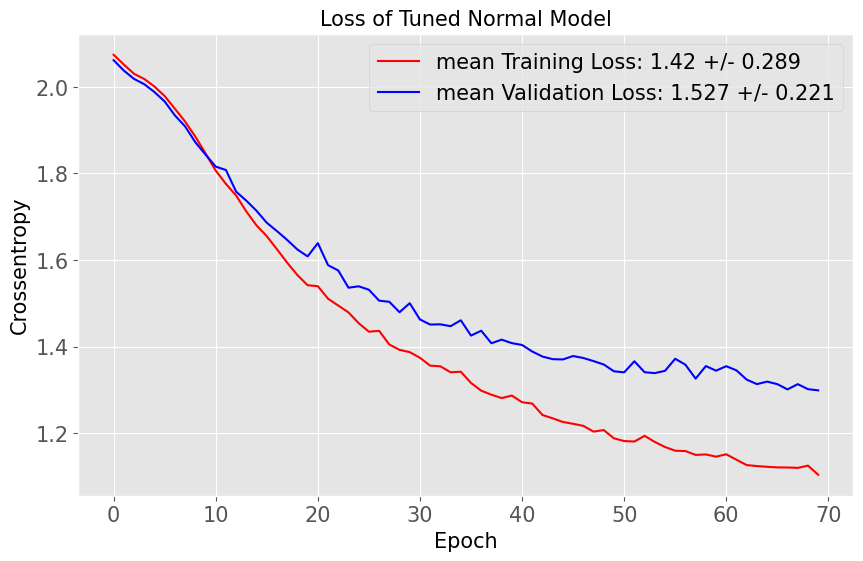

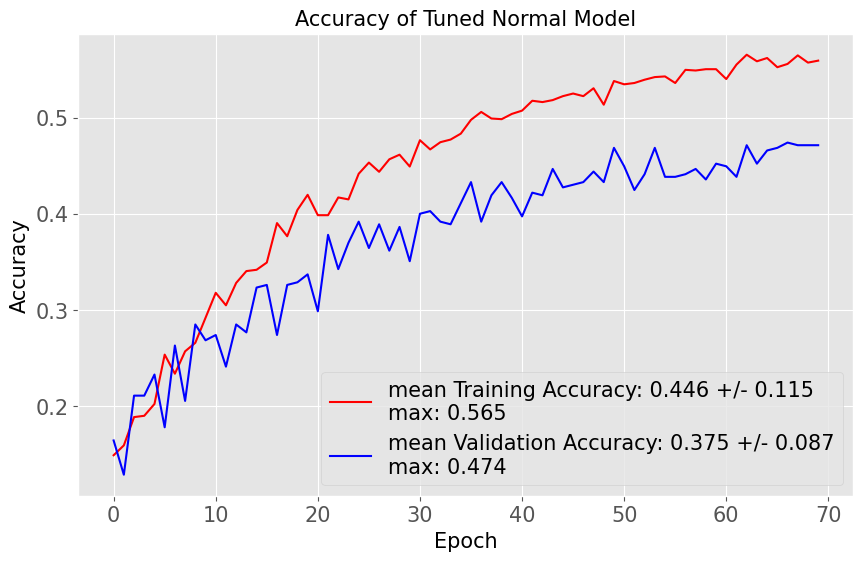

In [35]:
# testing the tuned NN variants
tf.keras.backend.clear_session()
ANN_normal = tuned_nn()
history_normal = ANN_normal.fit(X_train, y_train, validation_data=(X_val, y_val),
                              epochs=70, batch_size = 120, verbose = 0)
plot_trainVal(history_normal, 'Tuned Normal Model')

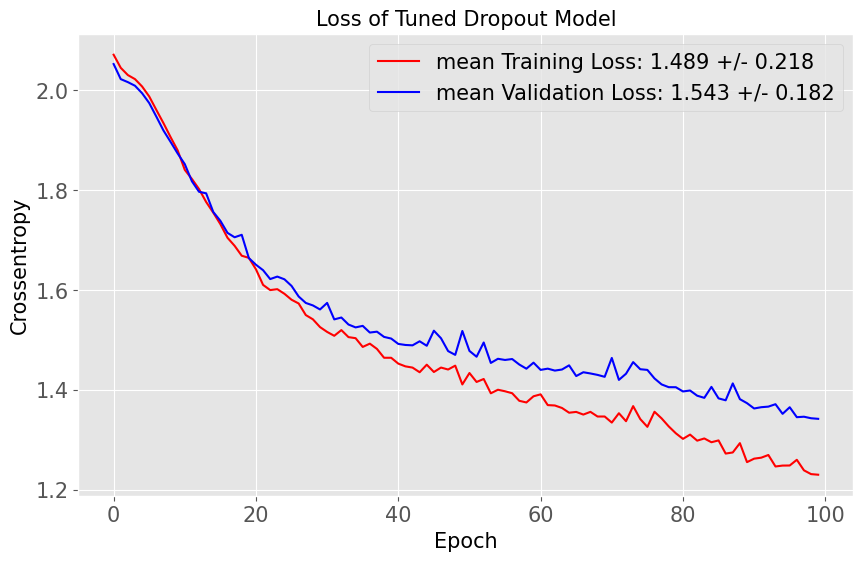

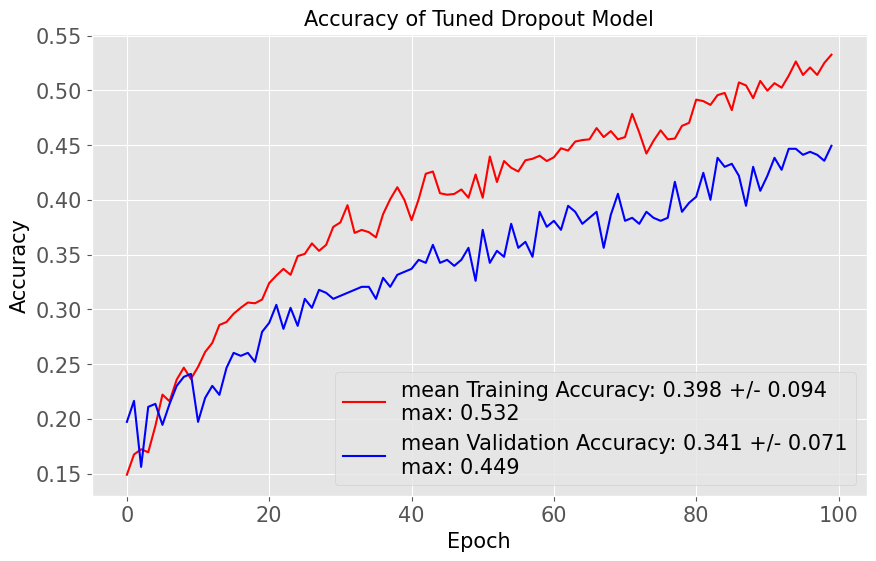

In [36]:
# testing the tuned NN variants
tf.keras.backend.clear_session()
ANN_dropout = tuned_nn_dropout()
history_dropout = ANN_dropout.fit(X_train, y_train, validation_data=(X_val, y_val),
                              epochs=100, batch_size = 120, verbose = 0)
plot_trainVal(history_dropout, 'Tuned Dropout Model')

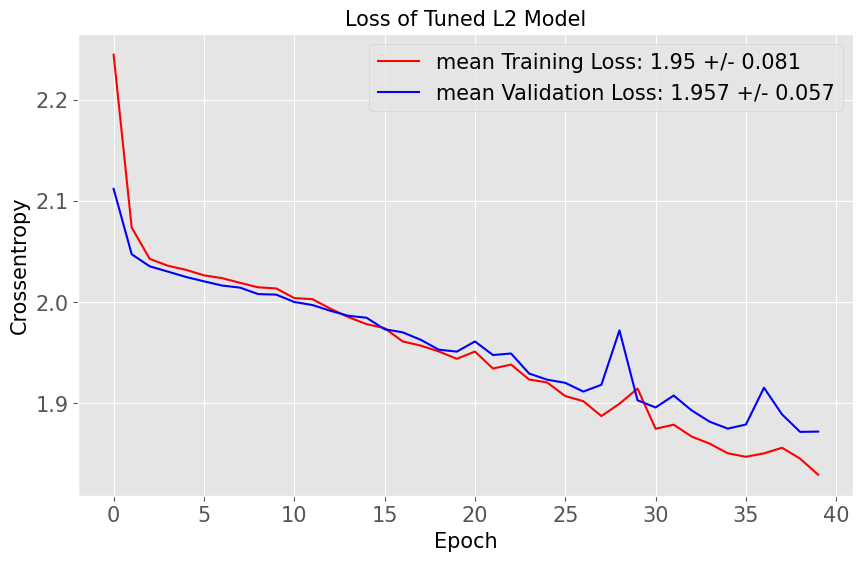

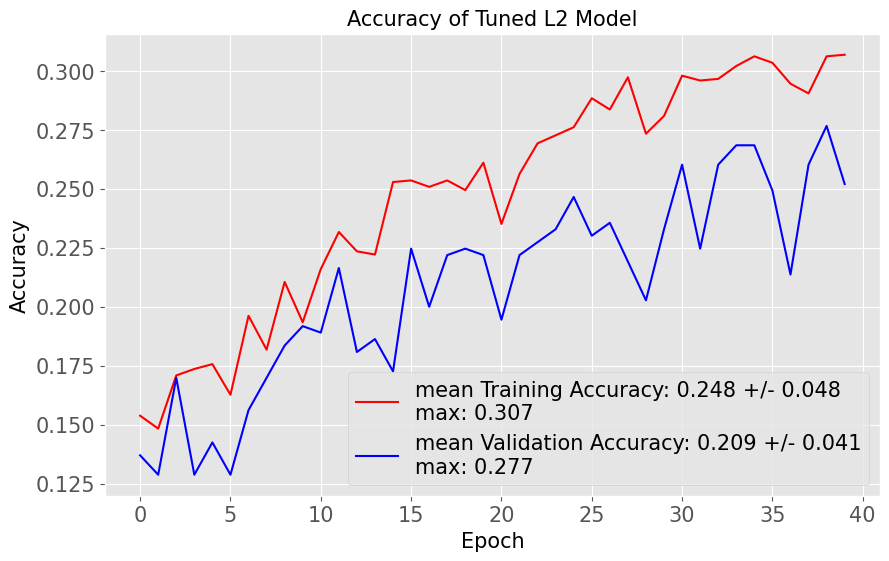

In [37]:
# testing the tuned NN variants
tf.keras.backend.clear_session()
ANN_l2 = tuned_nn_l2()
history_l2 = ANN_l2.fit(X_train, y_train, validation_data=(X_val, y_val),
                              epochs=40, batch_size = 60, verbose = 0)
plot_trainVal(history_l2, 'Tuned L2 Model')

## Testing the tuned NN variants

In [38]:
warnings.filterwarnings('ignore')

In [39]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall, plot_precision_recall_curve
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import multilabel_confusion_matrix

In [40]:
rand_state = 100

### Normal NN

20/20 [==============================] - 0s 576us/step
Accuracy: 0.4807692307692308

F1-score: [0.65236052 0.54166667 0.42990654 0.32835821 0.40201005 0.54545455
 0.3956044  0.47058824]

              precision    recall  f1-score   support

       angry       0.55      0.79      0.65        96
        calm       0.54      0.54      0.54        96
     disgust       0.39      0.48      0.43        48
     fearful       0.58      0.23      0.33        96
       happy       0.39      0.42      0.40        96
     neutral       0.53      0.56      0.55        48
         sad       0.42      0.38      0.40        96
   surprised       0.44      0.50      0.47        48

    accuracy                           0.48       624
   macro avg       0.48      0.49      0.47       624
weighted avg       0.49      0.48      0.47       624

20/20 [==============================] - 0s 525us/step


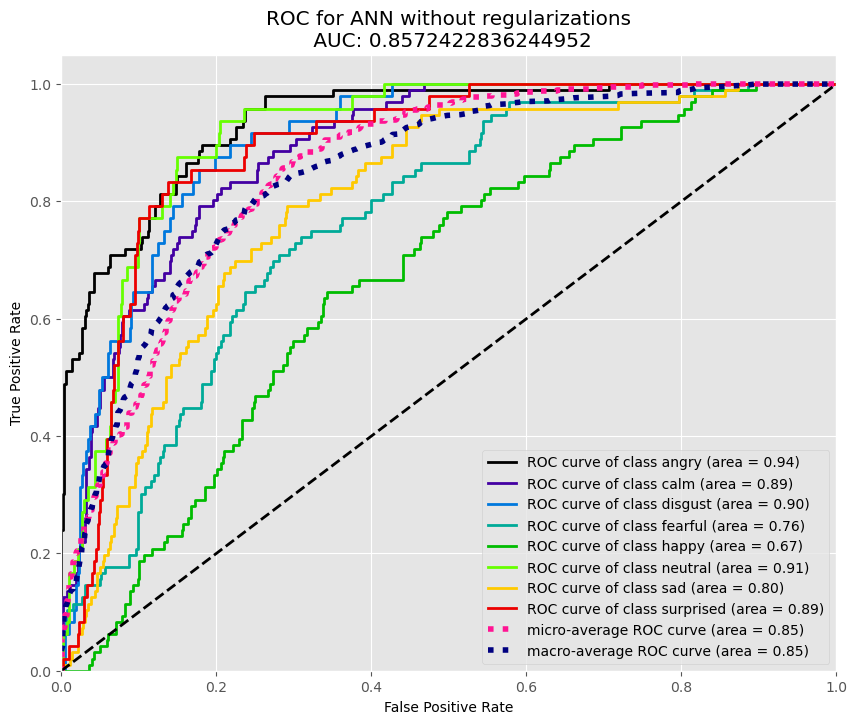

In [41]:
tf.keras.backend.clear_session()
ANN_normal = KerasClassifier(tuned_nn, random_state = rand_state)
ANN_normal = ANN_normal.fit(X, y, epochs=70, batch_size = 120, verbose = 0)

y_hat_normal = ANN_normal.predict(X_test).ravel()
acc_score_normal = accuracy_score(y_test, y_hat_normal)
f1_normal = f1_score(y_test, y_hat_normal, average=None)

print(f'Accuracy: {acc_score_normal}')
print()
print(f'F1-score: {f1_normal}')
print()
print(classification_report(y_test, y_hat_normal, target_names=label_encoder_name_mapping))

y_test_pred_proba = ANN_normal.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

y_test_dec = le.inverse_transform(y_test)

plot_roc(y_test_dec, ANN_normal.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for ANN without regularizations\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()

#plot_precision_recall_curve(y_test_dec, y_proba, figsize=(12,10))
#plt.show()

### Dropout NN

20/20 [==============================] - 0s 577us/step
Accuracy: 0.4519230769230769

F1-score: [0.62650602 0.52941176 0.45378151 0.35064935 0.34682081 0.46153846
 0.28       0.44444444]

              precision    recall  f1-score   support

       angry       0.51      0.81      0.63        96
        calm       0.50      0.56      0.53        96
     disgust       0.38      0.56      0.45        48
     fearful       0.47      0.28      0.35        96
       happy       0.39      0.31      0.35        96
     neutral       0.49      0.44      0.46        48
         sad       0.39      0.22      0.28        96
   surprised       0.40      0.50      0.44        48

    accuracy                           0.45       624
   macro avg       0.44      0.46      0.44       624
weighted avg       0.44      0.45      0.43       624

20/20 [==============================] - 0s 577us/step


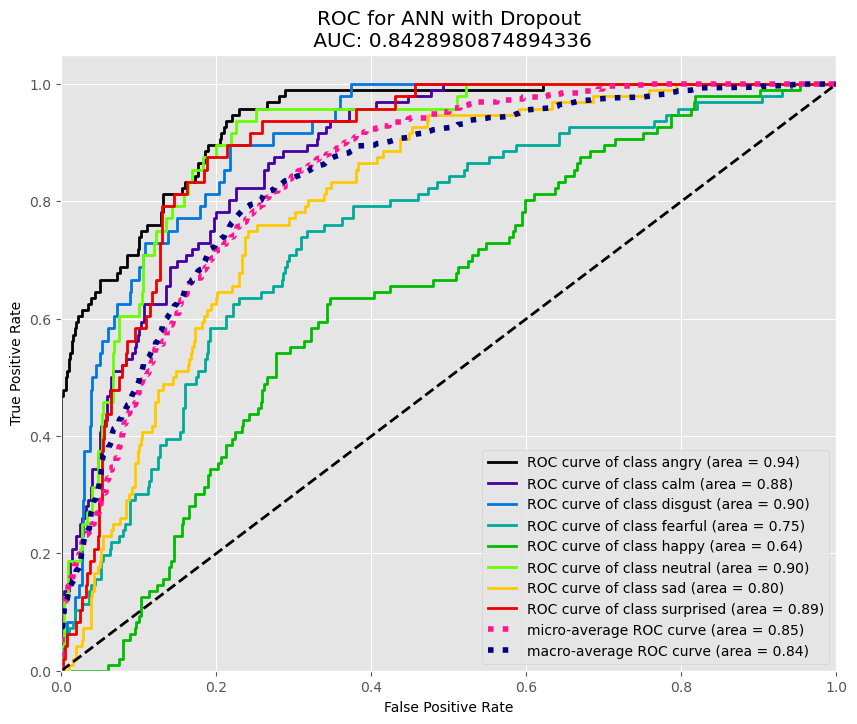

In [42]:
tf.keras.backend.clear_session()
ANN_dropout = KerasClassifier(tuned_nn_dropout(0.3), random_state = rand_state)
ANN_dropout = ANN_dropout.fit(X, y, epochs=100, batch_size = 120, verbose = 0)

y_hat_dropout = ANN_dropout.predict(X_test).ravel()
acc_score_dropout = accuracy_score(y_test, y_hat_dropout)
f1_dropout = f1_score(y_test, y_hat_dropout, average=None)

print(f'Accuracy: {acc_score_dropout}')
print()
print(f'F1-score: {f1_dropout}')
print()
print(classification_report(y_test, y_hat_dropout, target_names=label_encoder_name_mapping))

y_test_pred_proba = ANN_dropout.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

plot_roc(y_test_dec, ANN_dropout.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for ANN with Dropout\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()

#plot_precision_recall_curve(y_test_dec, y_proba, figsize=(12,10))
#plt.show()

### L2 NN

20/20 [==============================] - 0s 525us/step
Accuracy: 0.33974358974358976

F1-score: [0.62857143 0.47619048 0.08       0.25641026 0.34196891 0.
 0.08974359 0.        ]

              precision    recall  f1-score   support

       angry       0.70      0.57      0.63        96
        calm       0.32      0.94      0.48        96
     disgust       1.00      0.04      0.08        48
     fearful       0.25      0.26      0.26        96
       happy       0.34      0.34      0.34        96
     neutral       0.00      0.00      0.00        48
         sad       0.12      0.07      0.09        96
   surprised       0.00      0.00      0.00        48

    accuracy                           0.34       624
   macro avg       0.34      0.28      0.23       624
weighted avg       0.34      0.34      0.28       624

20/20 [==============================] - 0s 577us/step


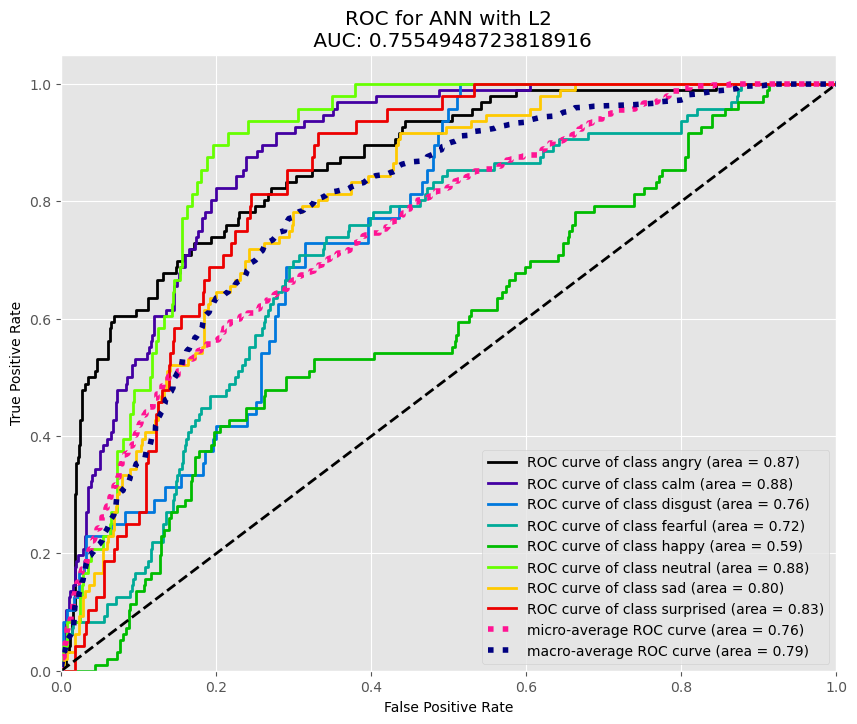

In [43]:
tf.keras.backend.clear_session()
ANN_l2 = KerasClassifier(tuned_nn_l2(0.1), random_state = rand_state)
ANN_l2 = ANN_l2.fit(X, y, epochs=40, batch_size = 60, verbose = 0)

y_hat_l2 = ANN_l2.predict(X_test).ravel()
acc_score_l2 = accuracy_score(y_test, y_hat_l2)
f1_l2 = f1_score(y_test, y_hat_l2, average=None)

print(f'Accuracy: {acc_score_l2}')
print()
print(f'F1-score: {f1_l2}')
print()
print(classification_report(y_test, y_hat_l2, target_names=label_encoder_name_mapping))

y_test_pred_proba = ANN_l2.predict_proba(X_test)
y_proba = y_test_pred_proba/y_test_pred_proba.sum(axis=1,keepdims=1)

plot_roc(y_test_dec, ANN_l2.predict_proba(X_test), figsize=(10,8))
plt.title(f'ROC for ANN with L2\n AUC: {roc_auc_score(y_test_dec, y_proba, multi_class="ovr", average="micro")}')
plt.show()

#plot_precision_recall_curve(y_test_dec, y_proba, figsize=(12,10))
#plt.show()

## Some facts

SGD doesn't perform well at all, probably stuck in local minima of the loss function